Name: Shiska Raut <br>
ID: 1001526329

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

## Read training/evaluation data

**Argument(s):** 
1) filename: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y) <br>
2) dtype_x : datatype of features <br>
3) dtype_y: datatype of label <br>

**Return(s):** 'X, Y' where X is a numpy array of feature vectors and Y is the target label vector.
Note: Each column in the array(s) epresents a single datapoint.

In [2]:
def get_X_Y_arrays(filename, dtype_x, dtype_y):
    try:
        f = open(filename, 'r')
    except OSError:
        print(f'{filename} could not be opened.\n')
        sys.exit()
        
    # initialize list to store feature and labels for training data
    features = []             
    labels = []
    
    with f:
        line = f.readline()
        while line != '':
            # strip newline and outer parenthesis
            line = line.strip('\n')
            line = line.strip('( )')
            
            # extrace label and append to labels list
            single_label = line.split('), ')[-1]
            labels.append(single_label)
            
            # extrace features and append to features list
            feat = line.split('), ')[0].split(', ')
            features.append(feat)
            
            # read next line
            line = f.readline()
        
        # create dataframe of features and append labels
        X = np.array(features, dtype = dtype_x, ndmin = 2)
        
        # convert labels list to array
        Y = np.array(labels, dtype = dtype_y)
        
        return X, Y

### Provide Filename:
1) Training/evaluation file: name of a .txt file with each line containing training/evaluation features(x) and label(y) in the following format:
((x1, x2, .....xn), y)

In [3]:
fname_train = 'data.txt'

X_train, Y_train = get_X_Y_arrays(fname_train, float, str)

### Plot class distribution of training data provided in assignment

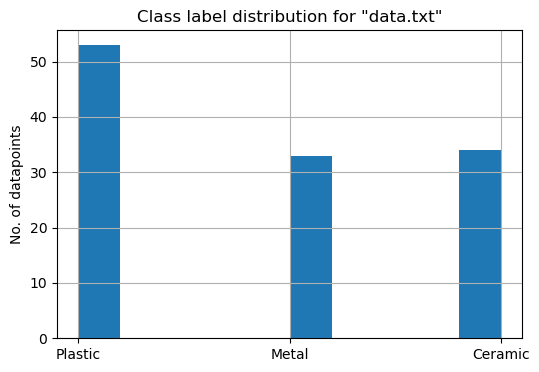

In [4]:
plt.figure(figsize = (6, 4))
plt.title(f'Class label distribution for "{fname_train}"')
plt.ylabel('No. of datapoints')
plt.hist(Y_train.squeeze())
plt.grid()

In [5]:
X_train.shape

(120, 4)

In [6]:
Y_train

array(['Plastic', 'Plastic', 'Metal', 'Plastic', 'Metal', 'Plastic',
       'Metal', 'Metal', 'Metal', 'Metal', 'Ceramic', 'Plastic', 'Metal',
       'Plastic', 'Plastic', 'Metal', 'Plastic', 'Ceramic', 'Ceramic',
       'Metal', 'Plastic', 'Metal', 'Plastic', 'Ceramic', 'Metal',
       'Metal', 'Plastic', 'Ceramic', 'Ceramic', 'Plastic', 'Metal',
       'Plastic', 'Metal', 'Plastic', 'Metal', 'Ceramic', 'Plastic',
       'Plastic', 'Plastic', 'Plastic', 'Metal', 'Plastic', 'Metal',
       'Plastic', 'Ceramic', 'Metal', 'Plastic', 'Metal', 'Plastic',
       'Ceramic', 'Metal', 'Plastic', 'Ceramic', 'Metal', 'Ceramic',
       'Plastic', 'Metal', 'Ceramic', 'Plastic', 'Plastic', 'Plastic',
       'Plastic', 'Ceramic', 'Metal', 'Metal', 'Ceramic', 'Metal',
       'Plastic', 'Ceramic', 'Metal', 'Metal', 'Ceramic', 'Ceramic',
       'Plastic', 'Plastic', 'Plastic', 'Ceramic', 'Plastic', 'Plastic',
       'Ceramic', 'Ceramic', 'Metal', 'Ceramic', 'Ceramic', 'Ceramic',
       'Ceramic', 'Cera

### 1 a) KNN

#### Helper functions

In [7]:
# randomly initializes 'k' distinct centroids given data 'X'
# centroids lie within the range of datapoints
def initialize_cluster_centroids(X, k):

    # get number of features
    n_feat = X.shape[1]

    # create dictionary to be able to number centroids
    centroids_dict = {}

    for i in range(k):

        # pick a random point
        random_idx = np.random.randint(0, X.shape[0])

        centroids_dict[i] = X[random_idx].reshape(1, n_feat)

    return centroids_dict


# given datapoints and cluster centroids, returns array with key
# of the closest cluster
def get_cluster_assignments(X, centroids_dict):

    # get number of centroids
    n_c = len(centroids_dict.keys())
    n_feat = X.shape[1]

    # get number of samples
    n_samp = X.shape[0]

    # initialize arr to store distance from each centroid
    dist_arr = np.zeros((n_samp, n_c))

    # calculate distance from each centroid
    for i in range(n_c):
        
        # get distance from each centroid
        dist_arr[:, i] = np.sqrt(np.sum((X - centroids_dict[i]) ** 2, axis=1))

    # get index of the lowest distance over rows(diff clusters)
    # the indx corresponds to the cluster key
    cluster_assignments = np.argmin(dist_arr, axis=1)

    return cluster_assignments


# given datapoints and number of the closeast cluster,
# computes new centroids
def compute_cluster_centroids(X, cluster_assignments):

    # initalize dict to store centroids
    centroids_dict = {}

    n_samp, n_feat = X.shape

    # get number of clusters
    n_c = np.max(cluster_assignments) + 1

    for i in range(n_c):

        # datapoints belonging to cluster i
        x_i = X[cluster_assignments == i]
        
        # if there are no datapoints assignd to the cluster
        if x_i.shape[0] != 0:
            centroids_dict[i] = np.sum(x_i, axis = 0) / x_i.shape[0]
        else:
            centroids_dict[i] = np.sum(x_i, axis=0)

    return centroids_dict


# given datapoints, assigned_cluster and centroids, computes the
# average squared distance of the clusters
def get_average_squared_distance(X, cluster_assignments, centroids_dict):

    n_samp, n_feat = X.shape

    # get number of clusters
    n_c = np.max(cluster_assignments) + 1

    # stores average squared distance
    sum_sq_dist = 0

    # for each cluster
    for i in range(n_c):
        # calculate distance between datapoints belonging to cluster i
        # with centroid of cluster i
        dist_arr = np.sum((X[cluster_assignments == i] - centroids_dict[i]) ** 2, axis=1)

        # calculate sum of squared distances
        sum_sq_dist = sum_sq_dist + np.sum(dist_arr)

    return sum_sq_dist / n_c


def get_predictions(X_train, Y_train, cluster_assignments):

    n_samp, n_feat = X_train.shape

    # get number of clusters
    n_c_list = np.unique(cluster_assignments).tolist()

    # create array to store predictions
    Y_pred = np.zeros(n_samp, dtype = object)

    # create dict to store majority label for the cluster
    cluster_labels = {}

    # concatenate X with cluster assignments and actual labels
    # to assign predicted labels
    X = np.concatenate((X_train, Y_train.reshape(n_samp,1)), axis = 1)

    for n in n_c_list:

        # get actual labels for all datapoints assigned to cluster number i
        labels = X[cluster_assignments == n][:, -1]

        # get count of each label
        values, counts = np.unique(labels, return_counts = True)

        # index of label with the highest count
        mode_idx = np.argmax(counts)

        # label with the highest count
        mode = values[mode_idx]

        # save label of the given cluster
        cluster_labels[n] = mode

    for i in range(n_samp):

        # get predicted labels from each sampple according to the
        # cluster it belongs to
        Y_pred[i] = cluster_labels[cluster_assignments[i]]

    return Y_pred


# returns weighted accuracy
def get_weighted_acc(Y_pred, Y_train, cluster_assignments):

    # get number of samples and clusters
    n_samp = Y_pred.shape[0]
    n_c_list = np.unique(cluster_assignments).tolist()

    # concat values for easy computation
    Y = np.concatenate((Y_train.reshape(n_samp, 1), Y_pred.reshape(n_samp, 1),
                        cluster_assignments.reshape(n_samp, 1)), axis=1)

    # initalize array to store weights and accuracy
    weights = np.zeros((1, len(n_c_list)))
    acc = np.zeros((1, len(n_c_list)))

    for i, n in enumerate(n_c_list):
        # all prediction values belonging to cluster i
        y_i = Y[cluster_assignments == n]

        # weight for cluster i
        weights[0, i] = y_i.shape[0] / n_samp

        # accuracy for cluster i
        acc[0, i] = np.sum((y_i[:, 0] == y_i[:, 1])) / y_i.shape[0]

    # caluclate the weighted sum
    weighted_acc = np.sum(weights * acc)

    return weighted_acc

# compares two arrays and returns class accuracy
def get_class_acc(Y_pred, Y):
    
    # create a dict to store class accuracy
    class_acc = {}
    
    # get all unique classes
    classes = set(Y.tolist())
    
    # get number of samples
    n_samples = Y_pred.shape[0]
    
    # calculate total occurence and accurate predictions for each class
    for c in classes:
        
        total = 0
        acc_vals = 0
        
        for i in range(n_samples):
            if Y[i] == c:
                total = total + 1
                if Y[i] == Y_pred[i]:
                    acc_vals = acc_vals + 1
                
        class_acc[c] = acc_vals/total
        
    return class_acc

#### Clustering Algorithm

In [8]:
# given an unlabeled data, returns k number of clusters
def get_kmeans_clusters(X, k):

    # initalize cluster centroids
    cluster_centroids_dict = initialize_cluster_centroids(X, k)

    # initialize list to store average squared distance
    avg_sq_dist_list = []

    # get new cluster assignments
    prev_cluster_assignments = get_cluster_assignments(X, cluster_centroids_dict)

    while True:

        # compute centroids
        cluster_centroids_dict = compute_cluster_centroids(X, prev_cluster_assignments)

        # add average squared distance
        avg_sq_dist_list.append(get_average_squared_distance(X, prev_cluster_assignments, cluster_centroids_dict))

        # get new cluster assignments
        cluster_assignments = get_cluster_assignments(X, cluster_centroids_dict)

        # if new assignments is same as the old assignments, stop
        if (prev_cluster_assignments == cluster_assignments).all():
            break

        # save new assignments
        prev_cluster_assignments = cluster_assignments

    return cluster_assignments, avg_sq_dist_list[-1]

### 1 b) k = 3, 6 and 9

In [9]:
## initialize list to store weighted accuracy values
acc_vals = []
class_acc_vals = []
avg_sq_dist_list = []
k_list = [3, 6, 9]

for k in k_list:
    final_cluster_assignments, avg_sq_dist = get_kmeans_clusters(X_train, k)
    Y_pred = get_predictions(X_train, Y_train, final_cluster_assignments)
    acc_vals.append(get_weighted_acc(Y_pred, Y_train, final_cluster_assignments))
    class_acc_vals.append(get_class_acc(Y_pred, Y_train))
    avg_sq_dist_list.append(avg_sq_dist)

#### Print Accuracy Values

In [10]:
for i, k in enumerate(k_list):
    print(f'The weighted accuracy for k = {k} is {acc_vals[i]:0.3f}.')

The weighted accuracy for k = 3 is 0.442.
The weighted accuracy for k = 6 is 0.458.
The weighted accuracy for k = 9 is 0.508.


In [17]:
for i in range(len(class_acc_vals)):
    print(f'\nThe class accuracy for k = {k_list[i]} is:')
    for k, v in class_acc_vals[i].items():
        print(f'{k}: {v:0.3f}')


The class accuracy for k = 3 is:
Plastic: 1.000
Ceramic: 0.000
Metal: 0.000

The class accuracy for k = 6 is:
Plastic: 0.906
Ceramic: 0.000
Metal: 0.212

The class accuracy for k = 9 is:
Plastic: 0.755
Ceramic: 0.176
Metal: 0.455


### Plot Average squared distance error

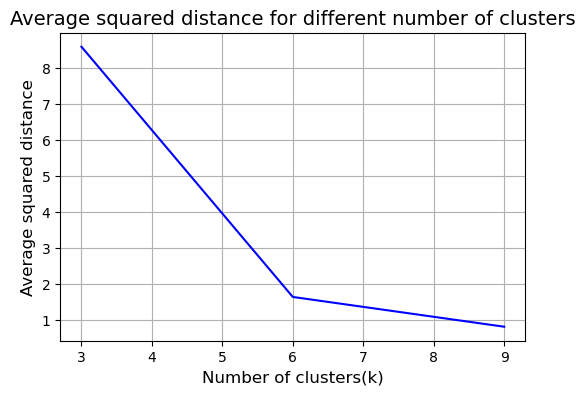

In [19]:
plt.figure(figsize = (6, 4))
plt.plot(k_list, avg_sq_dist_list, color = 'blue')

# add title and labels
plt.title('Average squared distance for different number of clusters', fontdict = {'fontsize': 14})
plt.xlabel('Number of clusters(k)', fontdict = {'fontsize': 12})
plt.ylabel('Average squared distance', fontdict = {'fontsize': 12})
plt.grid()